In [1]:
import torch
import skimage
import skimage.transform
from skimage import io
import numpy as np
import pytorch_lightning as pl
import torchvision as tv
from matplotlib import pyplot as plt
import torchvision.transforms.functional as TVF
import os
from os.path import exists

In [14]:
load_pattern = ['data/*.png']

In [12]:
def load_func(file_path):
    if 'png' in file_path:
        image = io.imread(file_path, as_gray=True)
        image = skimage.util.img_as_ubyte(image)
        image = image[:, :, None]
    else:
        image = io.imread(file_path)
        image = (image - image.min()) / image.max()
        image = skimage.util.img_as_ubyte(image)

    image_resized = TVF.resize(TVF.to_pil_image(image), (7500, 7500))
    image_resized = TVF.to_tensor(image_resized).permute(1, 2, 0)
    image_resized = skimage.util.img_as_ubyte(image)

    return image_resized

In [15]:
ic = io.ImageCollection(load_pattern, load_func=load_func)
ic.files

['data/Brookton,Maine,ME_(0,1)_buildings.png']

In [16]:
x = ic[0]

In [ ]:
x.shape

Error: Session cannot generate requests

In [34]:
file_path = 'resized.png'

satellite = io.imread(file_path)
streets = io.imread('streets_resized.png')

In [23]:
s = tv.utils.draw_segmentation_masks(torch.from_numpy(satellite[:, :, :3]).permute(2, 0, 1), torch.from_numpy(streets).to(torch.bool), alpha=0.5)

In [24]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = TVF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

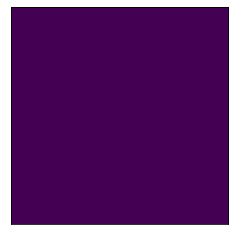

In [31]:
show(torch.from_numpy(streets))

/home/mboss/ai4good_map/venv/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


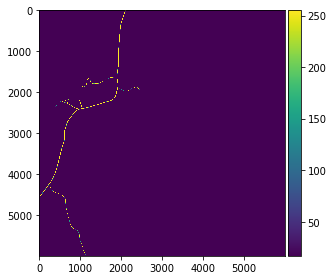

In [35]:
io.imshow(streets)

In [ ]:
io.imshow(satellite[:, :, :3])

Error: Session cannot generate requests

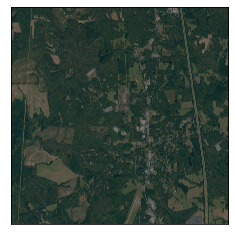

In [25]:
show(s)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_pattern = 'image.tif'

In [4]:
file_path=load_pattern

In [5]:
def load_func(file_path):
    if 'buildings' in file_path or 'streets' in file_path:
        image = io.imread(file_path, as_gray=True).astype(np.unit8)
    else:
        image = io.imread(file_path)
        image = (image - image.min()) / image.max()

    
    

In [6]:
satellite = io.imread(file_path)

In [7]:
satellite.shape

(6008, 7371, 4)

In [8]:
x = skimage.transform.resize(satellite, (6000, 6000, 4), anti_aliasing=True)

In [ ]:
x.shape

In [3]:
ic = io.ImageCollection('image.tif', )

In [4]:
x = ic[0]

In [5]:
x = (x - x.min()) / x.max()

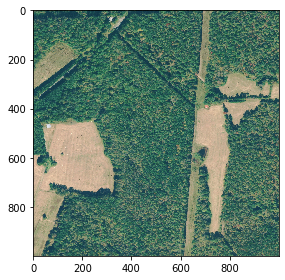

In [6]:
io.imshow(x[:1000, :1000, :3])

Loads tif images stored in folder satellite in same structure as in drive.
Splits images into 300x300 and saves the result in data folder.

In [ ]:
os.chdir('satellite')

In [ ]:
picture_paths = [[{ 'country': dir, 'picture': picture_path, 'path': ('./%s/Ortho/' % dir) + picture_path } for picture_path in os.listdir('./%s/Ortho/' % dir)] for dir in os.listdir('.')]

In [ ]:
def split_images(imgs, kernel_size=300, stride=300):
    if len(imgs.shape) == 3:
        imgs = imgs[None, :, :, :]
    
    B, C, H, W = imgs.shape
    
    patches = imgs.float().unfold(3, kernel_size, stride).unfold(2, kernel_size, stride).permute(0, 1, 2, 3, 5, 4)

    return patches.contiguous().view(patches.shape[0], patches.shape[1], patches.shape[2] * patches.shape[3], patches.shape[4], patches.shape[5]).squeeze(0).transpose(1, 0)

In [ ]:
for country in picture_paths:
    os.mkdir('../data/%s' % country[0]['country'])

    for place in country:
        img = torch.from_numpy(np.array(Image.open(place['path'])))[:, :, :3]
        img_splits = split_images(img.permute(2, 0, 1))
        
        for i, img_split in enumerate(img_splits):
            img_split_01 = img_split / img_split.max()
            img_split_01 -= img_split_01.min()

            tv.utils.save_image(img_split_01, '../data/%s/%s_%s.png' % (place['country'], place['picture'][:-4], i))